# XGBoost







XGBoost jest to komitet drzew regresyjnych, który stosuje się zarówno do problemu regresji jak i klasyfikacji. Wartość zwracana przez model (dla $i$-tej obserwacji):

$$\hat{y}_i = \sum\limits_{k=1}^K f_k(x_i),$$

gdzie $f_k(\cdot)$ - wartość zwracana przez $k$-te drzewo.


Predykcja zależy od problemu:

 1) Regresja

  - predykcja: $ pred_i = \hat{y}_i $
    

2) Klasyfikacja binarna

  - predykcja: $pred_i = p(x_i) = sigmoid(\hat{y}_i) = \frac{1}{1+\exp{(-\hat{y}_i)}}$
  
3) Klasyfikacja wieloklasowa

  - predykcja: $pred_i^c =softmax(\hat{y}_i)^c = \frac{\exp{(\hat{y}_i^c)}}{\sum\limits_c\exp{(\hat{y}_i^c)}}$




Uczenie modelu - budowanie komitetu - polega na konstruowaniu kolejnych drzew w taki sposób, aby zminimalizować fukcję celu:

### $$Obj(\Theta) = L(\Theta) + \Omega(\Theta),$$

gdzie

$\Theta$ - model (zestaw konkretnych drzew)

$L(\Theta)$ - funkcja straty (miara dopasowania modelu)

$\Omega(\Theta)$ - regularyzacja (miara złozoności modelu)

Fukcja straty zależy od problemu:

 1) Regresja
    
  - funkcja straty - kwadratowa: $\sum\limits_i (y_i - \hat{y}_i)^2$


2) Klasyfikacja binarna

  - funkcja straty - log-loss (_binomial cross-entropy_): $ - \frac{1}{n}\sum\limits_{i=1}^n \big( y_i\log(p(x_i)) + (1-y_i)\log(1-p(x_i))   \big) $

3) Klasyfikacja wieloklasowa

  - funkcja straty - log-loss (_multinomial cross-entropy_): $ = -\frac{1}{n}\sum\limits_{i=1}^n\sum\limits_c y_{ij} \log(p(x_i)_j) $


Drzewa uczone są iteracyjnie:

\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}

W danym kroku znajdujemy drzewo, które najlepiej poprawia naszą funkcję celu.

Regularyzacja:

\begin{split}\Omega(\Theta) = \sum_{i=1}^t\Omega(f_i),  \\
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2,
\end{split}

gdzie $T$ - liczba liści w drzewie $f$, $w_j$ wartość zwracana przez drzewo dla obseracji w $j$-tym liściu. Uwaga: wartości $w_{(\cdot)}$ są wyliczane na podstawie funkcji celu - w przybliżeniu znajdowane są takie, które dają najlepszy wynik.


W praktyce dodaje się kolejną regularyzację:

$$\hat{y}_i^{(k)} = \hat{y}_i^{(k-1)} + \eta \cdot f_k(x_i),$$

gdzie $\eta$ - _learning rate_.

https://xgboost.readthedocs.io/en/latest/model.html

In [95]:
# Wczytaj dane treningowe i testowe

import pandas as pd
train_set = pd.read_csv('Dane/adult.data', header=None)
test_set = pd.read_csv('Dane/adult.test', header=None, skiprows=1)

In [96]:
import numpy as np
import matplotlib.pyplot as plt

In [97]:
train_set.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [98]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [99]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [100]:
#Wyświetl informacje o typach zmiennych:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [101]:
# Usun braki danych (oznaczone jako ' ?', wzskazowka: da sie to zrobic przy uzyciu metod ramki danych)

train = train_set.replace(' ?', np.nan).dropna()
test = test_set.replace(' ?', np.nan).dropna()

train_set.shape, train.shape, test_set.shape, test.shape

((32561, 15), (30162, 15), (16281, 15), (15060, 15))

In [102]:
# Polacz zbiory

dataset = pd.concat([train, test])
print(dataset.shape)

(45222, 15)


In [103]:
# Zamien zmienna objasniana na binarna
dataset['wage_class'] = dataset.wage_class.replace({' <=50K.':0, ' <=50K':0, ' >50K':1, ' >50K.':1})
dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [113]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 13 columns):
age               45222 non-null int64
workclass         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null object
wage_class        45222 non-null int64
dtypes: int64(6), object(7)
memory usage: 4.8+ MB


In [104]:
#Usun zmienna fnlwgt
dataset.drop(labels='fnlwgt', axis=1, inplace=True)

In [105]:
dataset.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [106]:
#Zaproponuj sposbob obluzenia informacji dotyczących edukacji
dataset.drop(labels='education', axis=1, inplace=True)

In [107]:
dataset.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [114]:
#Wypisz informacje o rozkladach wszystkich zmiennych (nie tylko numerycznych)
dataset.describe(include='all')

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
count,45222.000000,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222.000000
unique,NaN,7,NaN,7,14,6,5,2,NaN,NaN,NaN,41,NaN
top,NaN,Private,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,NaN
freq,NaN,33307,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,NaN
mean,38.547941,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,0.247844
std,13.217870,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,0.431766
min,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,0.000000
25%,28.000000,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,0.000000
50%,37.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,0.000000
75%,47.000000,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,0.000000


In [115]:
# Wypisz czestosci poszczegolnych narodowosci
dataset.native_country.value_counts()

 United-States                 41292
 Mexico                          903
 Philippines                     283
 Germany                         193
 Puerto-Rico                     175
 Canada                          163
 El-Salvador                     147
 India                           147
 Cuba                            133
 England                         119
 China                           113
 Jamaica                         103
 South                           101
 Italy                           100
 Dominican-Republic               97
 Japan                            89
 Guatemala                        86
 Vietnam                          83
 Columbia                         82
 Poland                           81
 Haiti                            69
 Portugal                         62
 Iran                             56
 Taiwan                           55
 Greece                           49
 Nicaragua                        48
 Peru                             45
 

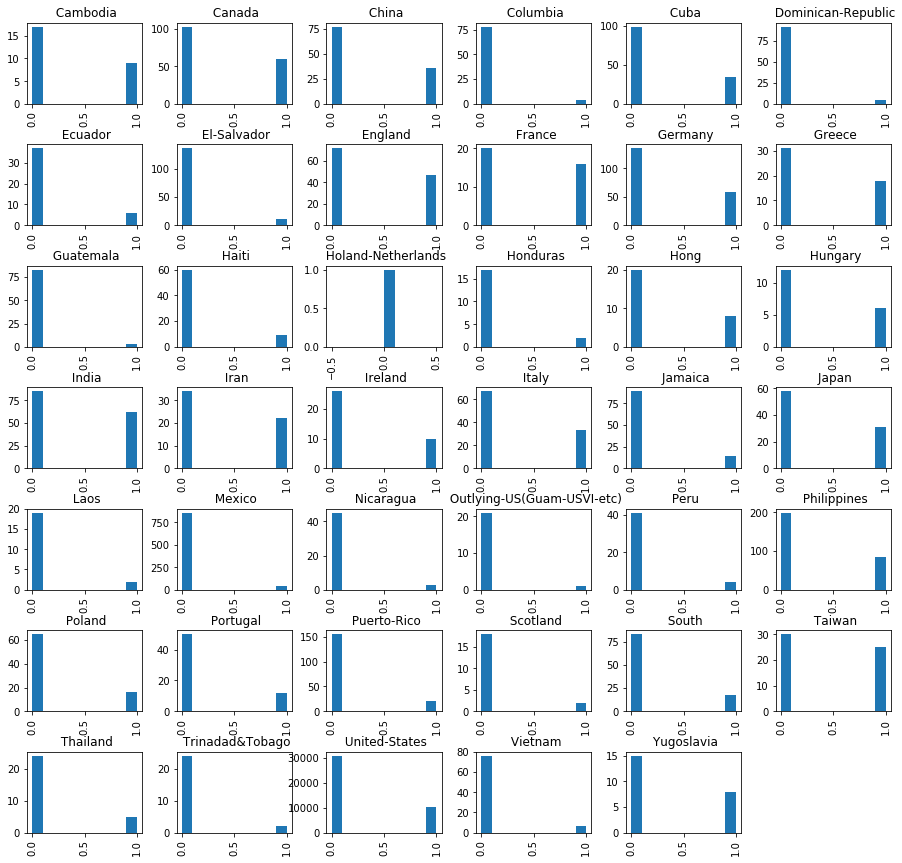

In [116]:
# Przeanalizuj rozklad y w zaleznosci od narodowosci:
# 1) rysujac histogramy w podgrupach wyznaczonych przez narodowosc

import matplotlib.pyplot as plt
%matplotlib inline

dataset['wage_class'].hist(by=dataset['native_country'], figsize=(15,15))
plt.show()

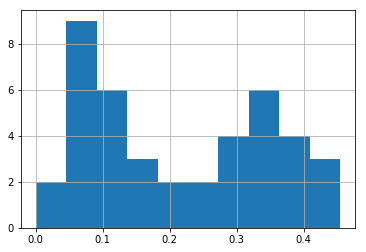

In [117]:
# 2) rysujac histogram proporcji w grupach
x = dataset.groupby('native_country')['wage_class'].mean()
x.hist()

In [119]:
# Zaproponuj sposob obsluzenia tej zmiennej

d = dict(pd.cut(x[x.index!=' United-States'], 5, labels=range(5)))
d

{' Cambodia': 3,
 ' Canada': 4,
 ' China': 3,
 ' Columbia': 0,
 ' Cuba': 2,
 ' Dominican-Republic': 0,
 ' Ecuador': 1,
 ' El-Salvador': 0,
 ' England': 4,
 ' France': 4,
 ' Germany': 3,
 ' Greece': 4,
 ' Guatemala': 0,
 ' Haiti': 1,
 ' Holand-Netherlands': 0,
 ' Honduras': 1,
 ' Hong': 3,
 ' Hungary': 3,
 ' India': 4,
 ' Iran': 4,
 ' Ireland': 3,
 ' Italy': 3,
 ' Jamaica': 1,
 ' Japan': 3,
 ' Laos': 1,
 ' Mexico': 0,
 ' Nicaragua': 0,
 ' Outlying-US(Guam-USVI-etc)': 0,
 ' Peru': 0,
 ' Philippines': 3,
 ' Poland': 2,
 ' Portugal': 2,
 ' Puerto-Rico': 1,
 ' Scotland': 1,
 ' South': 1,
 ' Taiwan': 4,
 ' Thailand': 1,
 ' Trinadad&Tobago': 0,
 ' Vietnam': 0,
 ' Yugoslavia': 3}

In [122]:
dataset['native_country'] = dataset['native_country'].replace(d)

In [125]:
dataset.head(10)

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,2,0
5,37,Private,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,1,0
7,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


In [126]:
# Zamien zmienne nominalne na numeryczne 
#(tak zeby zmienna o k-wartosciach byla reprezentowana przez k-1 zmiennych binarnych)
dataset = pd.get_dummies(dataset, drop_first=True)
dataset.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,wage_class,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_1,native_country_2,native_country_3,native_country_4,native_country_ United-States
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
2,38,9,0,0,40,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,1
3,53,7,0,0,40,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4,28,13,0,0,40,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [127]:
train.shape

(30162, 15)

In [129]:
train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

X_train.shape, X_test.shape

((30162, 45), (15060, 45))

### Zaczynamy modelowanie

Zaczynamy od określenia punktu wyjścia - naucz i przetestuj klasyfikator XGBoost. Interesują nas: accuracy orac AUC

In [133]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

In [134]:
model = XGBClassifier()
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, np.round(pred)), roc_auc_score(y_test, pred)

(0.86527224435590966, 0.91940434668823734)

In [146]:
#Podejście 1
model = XGBClassifier(learning_rate=0.4)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, np.round(pred)), roc_auc_score(y_test, pred)

(0.87058432934926955, 0.92694280548153773)

In [155]:
#Podejście 1
model = XGBClassifier(learning_rate=0.1, n_estimators=500)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, np.round(pred)), roc_auc_score(y_test, pred)

(0.87078353253652063, 0.92716075846973733)

In [158]:
#Podejście 1
model = XGBClassifier(learning_rate=0.4, n_estimators=500)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, np.round(pred)), roc_auc_score(y_test, pred)

(0.86845949535192568, 0.92525952845451098)

In [164]:
#Podejście 1
model = XGBClassifier(learning_rate=1, n_estimators=20)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, np.round(pred)), roc_auc_score(y_test, pred)

(0.86374501992031871, 0.92154678578226124)

In [160]:
from sklearn.model_selection import GridSearchCV

In [166]:
model = XGBClassifier(learning_rate=1, n_estimators=20)
params = {'max_depth':[5,7,10,12,15,17], \
            'min_child_weight': [5,10,15,20,25], \
            'reg_lambda': [0.5,1,2,4,8]}
grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(X_train, y_train)
# grid.grid_scores_
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 5, 'min_child_weight': 15, 'reg_lambda': 4}
0.865924010344


In [173]:
a = grid.be

AttributeError: 'XGBClassifier' object has no attribute 'best_estimator_'

In [170]:
grid = XGBClassifier(**grid.best_estimator_.get_param())
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

AttributeError: 'XGBClassifier' object has no attribute 'best_estimator_'

## Zadanie. Zbadaj schematy optymalizacji parametrów.

Podejście 1

Ustalamy małą liczbę drzew i duży learning rate. Następnie iteracyjnie optymalizujemy parametry: maksymalana głębokość drzew, minimalna liczb (waga) dzieci, parametr regularyzacji lambda, parametr gamma. Nastepnie zoptymalizuj liczbę drzew, learning rate i jeszcze raz pozostałe parametry. Przetestuj najlepszy model na zbiorze testowym.

Podejście 2

Ustalamy małą liczbę drzew i duży learning rate. Następnie "grid searchem" zoptymalizuj pozostałe parametry. Powtórz oba kroki dwukrotnie, uwzględniając wyniki z pierwszego kroku - zmień siatki parametrów tak, aby ich zakres nie był za duży i pokrywał okolice najlepszych parametrów.

Podejści 3

Ustalamy małą liczbę drzew i duży learning rate. Następnie randomizowany grid search po pozostałych parametrach dwuetapowy: w pierwszym etapie po prostu randomizowany grid search, a w drugim etapie zwykły grid search z mała siatką pokrywającą okolice najlepszych wyników. Na koniec zwiekszamy liczbę drzew zmiejszamy learning rate.


Inne sensowne podejście (Podobne do 1 i 2, lecz skrócone):
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# Case study 


Opis problemu i danych:
https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

Interesują nac dwie miary jakości: 
- AUC
- Zysk, liczony w następujący sposób:

  - zaklasyfikowanie obserwacji jako 1 kosztuje nas 100 zł
  - Trafienie predykcją w klasę 1 przynosi nam 1000 zł zarobku.

Cel: osiągnąć jak największy zysk.

In [246]:
bank = pd.read_csv('Dane/bank_train.csv', encoding='latin1')
bank[['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1']].head(100)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX
5,ID000010K00,Male,Bengaluru,45000,21-Apr-82,20-May-15,300000.0,5.0,15000.0,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,HSBC,Y,17,HAXM
6,ID000011L10,Female,Sindhudurg,70000,23-Oct-87,01-May-15,6.0,5.0,0.0,CARNIVAL CRUISE LINE,Yes Bank,N,0,HBXX
7,ID000012M20,Male,Bengaluru,20000,25-Jul-75,20-May-15,200000.0,5.0,2597.0,GOLDEN TULIP FLORITECH PVT. LTD,NaN,Y,3,HBXX
8,ID000013N30,Male,Kochi,75000,26-Jan-72,02-May-15,0.0,0.0,0.0,SIIS PVT LTD,State Bank of India,Y,13,HAXB
9,ID000014O40,Female,Mumbai,30000,12-Sep-89,03-May-15,300000.0,3.0,0.0,SOUNDCLOUD.COM,Kotak Bank,Y,0,HBXC


In [247]:
bank[['Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed']].head(100)

,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,200000.0,2.0,13.25,NaN,6762.90,N,Web-browser,G,S122,3,0,0
2,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0
5,300000.0,5.0,13.99,1500.0,6978.92,N,Web-browser,B,S143,3,1,0
6,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1,0,0
7,200000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S159,3,0,0
8,1300000.0,5.0,14.85,26000.0,30824.65,Y,Mobile,C,S122,5,0,0
9,300000.0,3.0,18.25,1500.0,10883.38,N,Web-browser,B,S133,1,0,0


In [248]:
bank.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed'],
      dtype='object')

In [249]:
bank.describe(include=[np.number])

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,LoggedIn,Disbursed
count,8.702000e+04,8.694900e+04,86949.000000,8.694900e+04,87020.000000,5.240700e+04,52407.000000,27726.000000,27420.000000,27726.000000,87020.000000,87020.000000,87020.000000
mean,5.884997e+04,2.302507e+05,2.131399,3.696228e+03,4.961503,3.950106e+05,3.891369,19.197474,5131.150839,10999.528377,2.949805,0.029350,0.014629
std,2.177511e+06,3.542068e+05,2.014193,3.981021e+04,5.670385,3.082481e+05,1.165359,5.834213,4725.837644,7512.323050,1.697720,0.168785,0.120062
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,5.000000e+04,1.000000,11.990000,200.000000,1176.410000,0.000000,0.000000,0.000000
25%,1.650000e+04,0.000000e+00,0.000000,0.000000e+00,0.000000,2.000000e+05,3.000000,15.250000,2000.000000,6491.600000,1.000000,0.000000,0.000000
50%,2.500000e+04,1.000000e+05,2.000000,0.000000e+00,2.000000,3.000000e+05,4.000000,18.000000,4000.000000,9392.970000,3.000000,0.000000,0.000000
75%,4.000000e+04,3.000000e+05,4.000000,3.500000e+03,11.000000,5.000000e+05,5.000000,20.000000,6250.000000,12919.040000,5.000000,0.000000,0.000000
max,4.445544e+08,1.000000e+07,10.000000,1.000000e+07,18.000000,3.000000e+06,6.000000,37.000000,50000.000000,144748.280000,7.000000,1.000000,1.000000


In [250]:
bank.describe(exclude=[np.number])

,ID,Gender,City,DOB,Lead_Creation_Date,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,87020,87020,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,11345,92,43567,57,2,19,2,2,7,30
top,ID076076A10,Male,Delhi,11-Nov-80,03-Jul-15,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,306,2315,4914,17695,56481,59294,67530,64316,37280,38567


In [251]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 26 columns):
ID                       87020 non-null object
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null object
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Var5                     87020 non-null int64
Var1                     87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null 

In [252]:
bank.drop('ID', axis=1, inplace=True)

In [253]:
bank.drop('Employer_Name', axis=1, inplace=True)

In [254]:
bank["Age"] = [115-int(s[-2:]) for s in bank.DOB]
bank.drop("DOB",axis=1,inplace=True)

In [255]:
bank.drop('Lead_Creation_Date', axis=1, inplace=True)

In [256]:
bank.drop('LoggedIn', axis=1, inplace=True)

In [257]:
bank['Source'] = bank['Source'].apply(lambda r: 'others' if r not in ['S122','S133'] else r)

In [258]:
bank['Interest_Rate'] = bank['Interest_Rate'].apply(lambda r: 0 if np.isnan(r) else 1)

In [265]:
bank['EMI_Loan_Submitted'] = bank['EMI_Loan_Submitted'].apply(lambda r: 0 if np.isnan(r) else 1)

In [275]:
bank['Loan_Amount_Submitted'] = bank['Loan_Amount_Submitted'].apply(lambda r: 0 if np.isnan(r) else 1)

In [ ]:
bank['Loan_Tenure_Submitted'] = bank['Loan_Tenure_Submitted'].apply(lambda r: 0 if np.isnan(r) else 1)

In [267]:
bank['Processing_Fee'] = bank['Processing_Fee'].apply(lambda r: 0 if np.isnan(r) else 1)

In [262]:
bank['Salary_Account'] = bank['Salary_Account'].apply( \
            lambda r: 'others' if r not in ['HDFC Bank', 'ICICI Bank', 'State Bank of India', 'Axis Bank'] else r)

In [271]:
bank['City'] = bank['City'].apply( \
            lambda r: 'others' if r not in ['Delhi', 'Bengaluru', 'Mumbai', 'Hyderabad', 'Chennai'] else r)

In [273]:
bank.head(20)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,Age
0,Female,Delhi,20000,300000.0,5.0,0.0,HDFC Bank,N,0,HBXX,...,0,0,0,N,Web-browser,G,S122,1,0,37
1,Male,Mumbai,35000,200000.0,2.0,0.0,ICICI Bank,Y,13,HBXA,...,1,0,1,N,Web-browser,G,S122,3,0,30
2,Male,others,22500,600000.0,4.0,0.0,State Bank of India,Y,0,HBXX,...,0,0,0,N,Web-browser,B,others,1,0,34
3,Male,others,35000,1000000.0,5.0,0.0,State Bank of India,Y,10,HBXX,...,0,0,0,N,Web-browser,B,others,3,0,28
4,Male,Bengaluru,100000,500000.0,2.0,25000.0,HDFC Bank,Y,17,HBXX,...,0,0,0,N,Web-browser,B,others,3,0,31
5,Male,Bengaluru,45000,300000.0,5.0,15000.0,others,Y,17,HAXM,...,1,1,1,N,Web-browser,B,others,3,0,33
6,Female,others,70000,6.0,5.0,0.0,others,N,0,HBXX,...,0,0,0,N,Web-browser,B,S133,1,0,28
7,Male,Bengaluru,20000,200000.0,5.0,2597.0,others,Y,3,HBXX,...,0,0,0,N,Web-browser,B,others,3,0,40
8,Male,others,75000,0.0,0.0,0.0,State Bank of India,Y,13,HAXB,...,1,1,1,Y,Mobile,C,S122,5,0,43
9,Female,Mumbai,30000,300000.0,3.0,0.0,others,Y,0,HBXC,...,1,1,1,N,Web-browser,B,S133,1,0,26


In [276]:
bank.describe(include=[np.number])

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,Disbursed,Age
count,8.702000e+04,8.694900e+04,86949.000000,8.694900e+04,87020.000000,87020.000000,87020.000000,87020.000000,87020.000000,87020.000000,87020.000000,87020.000000,87020.000000
mean,5.884997e+04,2.302507e+05,2.131399,3.696228e+03,4.961503,0.602241,0.602241,0.318616,0.315100,0.318616,2.949805,0.014629,30.904171
std,2.177511e+06,3.542068e+05,2.014193,3.981021e+04,5.670385,0.489438,0.489438,0.465943,0.464558,0.465943,1.697720,0.120062,7.147194
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
25%,1.650000e+04,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,26.000000
50%,2.500000e+04,1.000000e+05,2.000000,0.000000e+00,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,29.000000
75%,4.000000e+04,3.000000e+05,4.000000,3.500000e+03,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.000000,34.000000
max,4.445544e+08,1.000000e+07,10.000000,1.000000e+07,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,100.000000


In [277]:
bank.describe(exclude=[np.number])

,Gender,City,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,87020,87020,87020,87020,87020,87020,87020
unique,2,6,5,2,19,2,2,7,3
top,Male,others,others,Y,HBXX,N,Web-browser,B,S122
freq,49848,38686,35063,56481,59294,67530,64316,37280,38567


In [283]:
bank = pd.get_dummies(bank, drop_first=True)

In [284]:
bank.head(20)

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,...,Filled_Form_Y,Device_Type_Web-browser,Var2_B,Var2_C,Var2_D,Var2_E,Var2_F,Var2_G,Source_S133,Source_others
0,20000,300000.0,5.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,35000,200000.0,2.0,0.0,13,1,1,1,0,1,...,0,1,0,0,0,0,0,1,0,0
2,22500,600000.0,4.0,0.0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,35000,1000000.0,5.0,0.0,10,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
4,100000,500000.0,2.0,25000.0,17,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
5,45000,300000.0,5.0,15000.0,17,1,1,1,1,1,...,0,1,1,0,0,0,0,0,0,1
6,70000,6.0,5.0,0.0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
7,20000,200000.0,5.0,2597.0,3,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
8,75000,0.0,0.0,0.0,13,1,1,1,1,1,...,1,0,0,1,0,0,0,0,0,0
9,30000,300000.0,3.0,0.0,0,1,1,1,1,1,...,0,1,1,0,0,0,0,0,1,0


In [286]:
from sklearn.model_selection import train_test_split

In [287]:
X_train, X_test = train_test_split(bank.drop('Disbursed',1),test_size=0.2, stratify=bank.Disbursed, random_state=123)
y_train, y_test = train_test_split(bank.Disbursed,test_size=0.2, stratify=bank.Disbursed, random_state=123)

In [402]:
model = XGBClassifier(n_estimators=500)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]

accuracy_score(y_test, np.round(pred)), roc_auc_score(y_test, pred)

(0.98529073776143417, 0.85246815969375689)

In [403]:
np.sum(pred > 0.1)

297

In [404]:
np.sum(y_test == 1)

255

In [405]:
treshold = 0.1
1000*np.sum(((pred>treshold)==y_test) & (y_test==1))-100*np.sum(pred>treshold)

13300

In [ ]:
15900